# 1. Importing the Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

import matplotlib.pyplot as plt

# 2. Loading the Data & Preprocessing Artifacts

In [4]:
df = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [5]:
# Dropping the same columns
df.drop(columns=["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"], inplace=True)

In [6]:
# Encoding target
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})

In [7]:
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

X = pd.get_dummies(X, drop_first=True)

In [8]:
from sklearn.preprocessing import StandardScaler
import pickle

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
# Load scaler
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [12]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Model 1 - Logistic Regression

## The Model

In [14]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

## Evaluation

In [16]:
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.62      0.34      0.44        47

    accuracy                           0.86       294
   macro avg       0.75      0.65      0.68       294
weighted avg       0.84      0.86      0.84       294

ROC-AUC: 0.8079076578516668


We've set a baseline using Logistic Regression for complex models to beat.

# 4. Model 2 - Random Forest

## The Model

In [17]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

## Evaluation

In [18]:
print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.44      0.09      0.14        47

    accuracy                           0.84       294
   macro avg       0.65      0.53      0.53       294
weighted avg       0.78      0.84      0.79       294

ROC-AUC: 0.770695150314411


Why did we not Scale?


> Tree models don’t need feature scaling.



# 5. Model 3 - Gradient Boosting

## The Model

In [19]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]

## Evaluation

In [20]:
print("Gradient Boosting")
print(classification_report(y_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_gb))

Gradient Boosting
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       247
           1       0.59      0.21      0.31        47

    accuracy                           0.85       294
   macro avg       0.73      0.59      0.61       294
weighted avg       0.82      0.85      0.82       294

ROC-AUC: 0.7941252476526832


# 6. ROC Curve Comparison

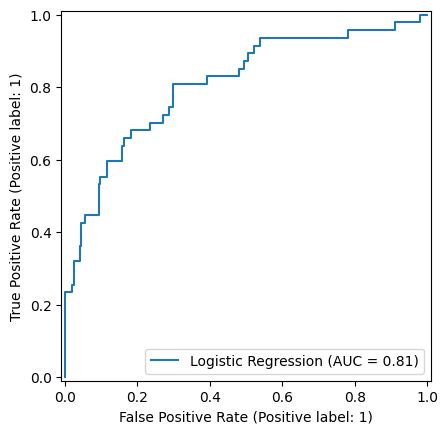

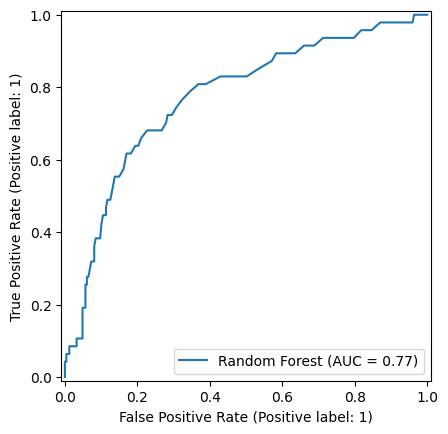

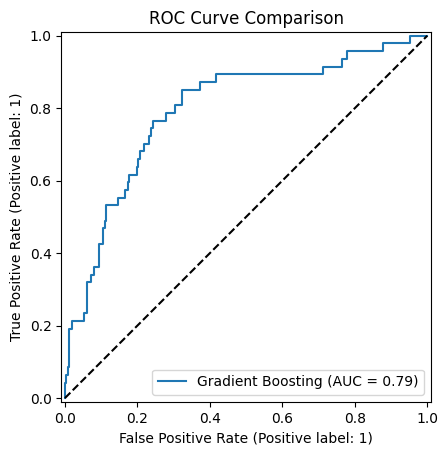

In [21]:
RocCurveDisplay.from_predictions(y_test, y_prob_lr, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, y_prob_rf, name="Random Forest")
RocCurveDisplay.from_predictions(y_test, y_prob_gb, name="Gradient Boosting")

plt.plot([0,1], [0,1], "k--")
plt.title("ROC Curve Comparison")
plt.show()


## Final Model Selection

After evaluating multiple models using ROC-AUC, Precision, Recall, and F1-score, **Logistic Regression achieved the best overall performance** with a ROC-AUC score of `0.81`.

Despite being a simpler model, Logistic Regression generalized better than tree-based models, indicating that the relationship between features and attrition is largely linear after encoding and scaling.

Due to its **strong performance, stability, and interpretability**, Logistic Regression was selected
as the final model for deployment.


# 7. Logistic Regression Coefficient Analysis

In [25]:
coeff_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

In [26]:
coeff_df.head(10)

,Feature,Coefficient
43,OverTime_Yes,0.864567
23,BusinessTravel_Travel_Frequently,0.751247
34,JobRole_Laboratory Technician,0.714756
21,YearsSinceLastPromotion,0.528704
11,NumCompaniesWorked,0.487609
40,JobRole_Sales Representative,0.481459
24,BusinessTravel_Travel_Rarely,0.450070
39,JobRole_Sales Executive,0.409361
2,DistanceFromHome,0.393594
42,MaritalStatus_Single,0.376877


In [24]:
coeff_df.tail(10)

,Feature,Coefficient
20,YearsInCurrentRole,-0.356016
27,EducationField_Life Sciences,-0.356181
37,JobRole_Research Director,-0.361341
6,JobInvolvement,-0.365340
22,YearsWithCurrManager,-0.398368
0,Age,-0.407597
29,EducationField_Medical,-0.414529
8,JobSatisfaction,-0.419417
4,EnvironmentSatisfaction,-0.481659
16,TotalWorkingYears,-0.555603


## **Model Interpretation (Logistic Regression)**

In Logistic Regression, feature coefficients represent the direction and strength of a feature’s impact on employee attrition:

- **Positive coefficients** increase the likelihood of attrition
- **Negative coefficients** reduce the likelihood of attrition

## **Key Factors Increasing Attrition Risk**
- **OverTime_Yes** is the strongest predictor of attrition, indicating that employees
  who frequently work overtime are significantly more likely to leave.
- **Frequent business travel** is associated with higher attrition, suggesting
  increased burnout or work–life imbalance.
- Certain **job roles**, particularly **Sales Representatives** and
  **Laboratory Technicians**, show higher attrition risk.
- **Longer duration since last promotion** and **higher number of previous employers**
  increase the probability of attrition.
- Employees who are **single** and those living **farther from the workplace**
  are more likely to leave.

## **Key Factors Reducing Attrition Risk**
- **TotalWorkingYears** and **Age** have strong negative coefficients, indicating
  that more experienced and older employees are less likely to leave.
- Higher **Job Satisfaction** and **Environment Satisfaction** significantly
  reduce attrition risk.
- Strong **managerial relationships** (YearsWithCurrManager) and
  **higher job involvement** are associated with improved retention.
- Employees in **Research Director roles** show notably lower attrition.

## **Business Interpretation**
These results suggest that employee attrition is strongly influenced by
**workload, career progression, job satisfaction, and role-specific pressures**.
Targeted interventions such as reducing excessive overtime, improving promotion
timelines, and enhancing employee engagement can significantly reduce attrition.

## **Actionable HR Recommendations**

Based on the insights derived from the model, the following strategies are recommended:

1. **Overtime Management**
   - Identify employees with frequent overtime and introduce workload balancing
   - Encourage flexible scheduling where possible

2. **Career Progression Planning**
   - Monitor employees with long promotion gaps
   - Introduce transparent promotion timelines and skill development plans

3. **Targeted Role-Based Interventions**
   - Provide additional support for high-attrition roles such as Sales and Lab Technicians
   - Conduct periodic engagement surveys for these teams

4. **Employee Engagement Programs**
   - Improve job satisfaction through recognition, mentorship, and feedback systems
   - Strengthen manager–employee relationships

5. **Attrition Risk Monitoring**
   - Use the deployed ML model to flag high-risk employees early
   - Enable proactive retention strategies instead of reactive hiring



# 8. Saving Final Model

In [28]:
import pickle

with open("attrition_model.pkl", "wb") as f:
    pickle.dump(lr, f)

**Modeling Summary**

- Trained and evaluated Logistic Regression, Random Forest, and Gradient Boosting models
- Used ROC-AUC, Precision, Recall, and F1-score for evaluation
- Addressed class imbalance using appropriate metrics
- Logistic Regression achieved the highest ROC-AUC (0.807)
- Selected Logistic Regression for its superior performance and interpretability
- Saved the trained model for deployment in a web application
